In [ ]:
!free -m
!df -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          13021         584       10277           0        2159       12159
Swap:             0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   32G   34G  49% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   16K  6.4G   1% /var/colab
/dev/sda1        75G   33G   43G  44% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Sun Apr 26 07:07:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id      

In [ ]:
# !pip install --upgrade torch torchvision
import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

Torch 1.4.0 CUDA 10.1


In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from numpy import load
import random
from PIL import Image

In [ ]:
# Download dataset from Continual AI Colab's repository
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 115 (delta 3), reused 8 (delta 1), pack-reused 97
Receiving objects: 100% (115/115), 206.64 KiB | 9.84 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
# Import the script 
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


In [ ]:
# Load dataset:
x_train, t_train, x_test, t_test = mnist.load()
print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


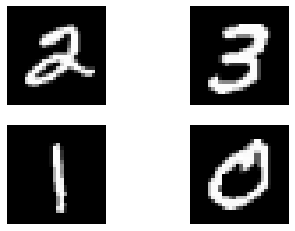

In [ ]:
# Display 4 images inside dataset
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[5, 0], cmap="gray")
axarr[0,1].imshow(x_train[7, 0], cmap="gray")
axarr[1,0].imshow(x_train[8, 0], cmap="gray")
axarr[1,1].imshow(x_train[21, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [ ]:
# switch to cuda GPU
# Q: Why using GPU? 
# A: cuz for some highly parallelizable problems, GPU can ensure us speedup computation 

use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
print(device)
# Use torch.manual_seed() to seed the RNG our CUDA devices
torch.manual_seed(2)

cuda


#  Part I:  instantiate model and start the training on original data

In [ ]:
# After comparing CNN and MLP's performance on MNIST, we decided to use MLP as the basic network architecture for this project
# Our MLP model consists of four fully connected hidden layers -- with 512, 256,128,10 units in each hidden layer by themselves;
# And use Rectified Linear Units(ReLUs) as activation function for each hidden layer;
# We also include a dropout layer (p=0.2) to precent the overfitting of data

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
        return x

In [ ]:
# We also compared different optimizers' performance including Stochastic Gradient Descent(SGD), 
# SGD with momentum, RMSprop and Adam. And we decided to use Adam since it has the highest training and validation accuracies
# for each epoch(94%~97%) while SGD has the lowest for each epoch where yields (84% ~ 89%).

model = MLP().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer =  optim.Adadelta(model.parameters())

# Here we also tried out different batch_size ranging from 128 to 512, and finally decided to use batch size as 200 since this gave
# us the highest accuracy among all others 
batch_size = 200

In [ ]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
#     Reshape the input size for the input of MLP:
      x = x.view(x.size(0), -1)
#     Set the gradients to zero before starting to do backpropragation:
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
#   Use model.eval() for batch norm and dropouts
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, batch_size):
      end = start + batch_size
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0), -1)
        output = model(x)
        # sum up batch loss
        test_loss += F.cross_entropy(output, y).item() 
        # get the index of the max logit
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [ ]:
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.349645
Test set: Average loss: 0.0004, Accuracy: 8300/10000 (83%)

Train Epoch: 2 	Loss: 0.101903
Test set: Average loss: 0.0001, Accuracy: 9643/10000 (96%)



# Part I Summary: 
Since we used the starter code from Continual AI Colab's repository, in the starter code, the network architecture used CNN and the final accuracy is **94%.** By changing architecture and improving parameterization we imporve the accuracy to **97%.** By improving the basic architecture, it will hlep to improve the performance of continual learning task on different model

In [ ]:
# Load MNIST again for rotated 
x_train_2, t_train_2, x_test_2, t_test_2 = mnist.load()

print("x_train dim and type: ", x_train_2.shape, x_train_2.dtype)
print("t_train dim and type: ", t_train_2.shape, t_train_2.dtype)
print("x_test dim and type: ", x_test_2.shape, x_test_2.dtype)
print("t_test dim and type: ", t_test_2.shape, t_test_2.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


# Part II : Rotate MNIST for different tasks

In [ ]:
# Here we developed our own rotation function other than importing other rotated MNIST dataset thus we only import data once 
# and the data format is consistant
def rotate_dataset(d, seed):
    torch.manual_seed(seed)
    print("starting rotation...")
    rand_rotate = torch.rand(1)
#     print( rand_rotate)
#   for each rotation of each task, we rotate them for a random angle between 0 to 360
    rotation = 360*rand_rotate 
#     print(rotation)
    rotated_mnist = np.ndarray((d.shape),np.float32)
    result = []
    new_d=[]

    for i in range(d.shape[0]):
        img = Image.fromarray(d[i][0])
#       Use the roattion fuction from PIL's Image Library 
        img = img.rotate(rotation)
        rotated_mnist[i,0]= img

    return rotated_mnist

starting rotation...
starting rotation...
x_train dim and type:  (60000, 1, 28, 28) float32
x_test dim and type:  (10000, 1, 28, 28) float32


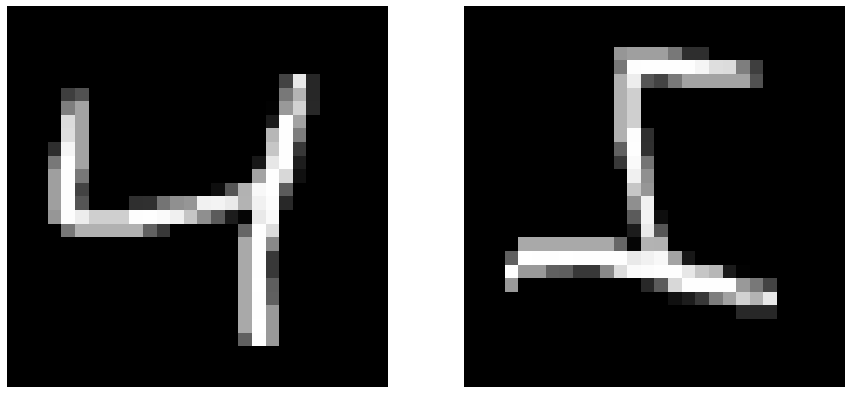

In [ ]:
# Rotate MNIST dataset 
x_train_2 = rotate_dataset(x_train, 1)
x_test_2 = rotate_dataset(x_test, 1)
print("x_train dim and type: ", x_train_2.shape, x_train_2.dtype)
print("x_test dim and type: ", x_test_2.shape, x_test_2.dtype)
# Displat rotated MNIST dataset
f, axarr = plt.subplots(1,2, figsize=(15, 10))
axarr[0].imshow(x_train[2,0], cmap="gray")
axarr[1].imshow(x_train_2[2,0], cmap="gray")
plt.savefig('ny1.jpg')
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [ ]:
# Test our model trained by non-rorated on rotated which only has 18% accuracy.
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test_2, t_test);

Testing on the first task:
Test set: Average loss: 0.0026, Accuracy: 3082/10000 (31%)

Testing on the second task:
Test set: Average loss: 0.0001, Accuracy: 9682/10000 (97%)



In [ ]:
# Finetune  our model using the new roated training set can reach a good acc of 97% 
for epoch in range(1, 3):
  train(model, device, x_train_2, t_train, optimizer, epoch)
  test(model, device, x_test_2, t_test)

Train Epoch: 1 	Loss: 0.080005
Test set: Average loss: 0.0001, Accuracy: 9729/10000 (97%)

Train Epoch: 2 	Loss: 0.074034
Test set: Average loss: 0.0001, Accuracy: 9767/10000 (98%)



In [ ]:
# However if we use our finetuned model on the original dataset, the acc is still very low:
print("Testing on the first task:")
test(model, device, x_test, t_test);
print("Testing on the second task:")
test(model, device, x_test_2, t_test)

Testing on the first task:
Test set: Average loss: 0.0032, Accuracy: 2675/10000 (27%)

Testing on the second task:
Test set: Average loss: 0.0001, Accuracy: 9767/10000 (98%)



97.67

In [ ]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
task_2 = [(x_train_2, t_train), (x_test_2, t_test)]

# task 3
x_train_3 = rotate_dataset(x_train, 4)
x_test_3 = rotate_dataset(x_test, 4)
task_3 = [(x_train_3, t_train), (x_test_3, t_test)]

# task 4
x_train_4 = rotate_dataset(x_train, 3)
x_test_4 = rotate_dataset(x_test, 3)
task_4 = [(x_train_4, t_train), (x_test_4, t_test)]

# task 5
x_train_5 = rotate_dataset(x_train, 9)
x_test_5 = rotate_dataset(x_test, 9)
task_5 = [(x_train_5, t_train), (x_test_5, t_test)]

# task 6
x_train_6 = rotate_dataset(x_train, 5)
x_test_6 = rotate_dataset(x_test, 5)
task_6 = [(x_train_6, t_train), (x_test_6, t_test)]

# task 7
x_train_7 = rotate_dataset(x_train, 8)
x_test_7 = rotate_dataset(x_test, 8)
task_7 = [(x_train_7, t_train), (x_test_7, t_test)]


# task 8
x_train_8 = rotate_dataset(x_train, 2)
x_test_8 = rotate_dataset(x_test, 2)
task_8 = [(x_train_8, t_train), (x_test_8, t_test)]

# task 9
x_train_9 = rotate_dataset(x_train, 0)
x_test_9 = rotate_dataset(x_test, 0)
task_9 = [(x_train_9, t_train), (x_test_9, t_test)]

# task 10
x_train_10 = rotate_dataset(x_train, 1)
x_test_10 = rotate_dataset(x_test, 1)
task_10 = [(x_train_10, t_train), (x_test_10, t_test)]


# task list
tasks=[task_1, task_2, task_3,task_4,task_5,task_6,task_7, task_8,task_9,task_10]
# tasks=[task_1, task_2, task_3]

starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...


* # **Part III: Implement Elastic Weights Consolidation (EWC) Strategy**

* **Introduction to the method:**

Accroding to paper [**Overcoming catastrophic forgetting in neural networks**](https://arxiv.org/pdf/1612.00796.pdf), EWC can prevent catastrophic forgetting by constraining important parameters to stay close to their old values when performing new tasks. 


While learning new task B, EWC therefore protects the performance in task A by constraining the parameters to
stay in a region of low error for task A centered around the set of weights and biases $\theta_A$

EWC also uses a posterior probability to justify this choice of constraint and decides which weights are most important for a task. In addition, it approximates the posterior as a Gaussian distribution with mean given by the parameters $\theta_A$ and a diagonal precision given by the diagonal of the Fisher information matrix F.

Here's the loss fucnction we're going to use in our project: 

# $L(\theta) = L_{B}(\theta) + \sum_{i}^{N}\frac{2}{\lambda}F_i(\theta_i-\theta_{i,A}^{*})^2$

Here, the **$ L_{B}(\theta) $ ** is the loss function for new task only, the ** $\lambda$ ** is the ewc lambda, which decides how important the previous task's parameters are to the new task, we also have **$i$** labels each parameter.

When EWC moving with the third task or more task, it will try to keep the network parameters close to the
learned parameters previous tasks since the sum of two quadratic penalties is itself a quadratic penalty.


* **Inplementation of EWC:**

In [ ]:
# Init dict/list for saving fisher information matrix and optmizated parameters from old task
fisher_dict = {}
optpar_dict = {}
# Init ewc lamda, which sets how important the old task is compared to the new one and i labels each parameter
# Experienment: how lamda affects the results of accuracy? This will be explained in the Part IV which will be shown later
# From our experiment on lambda, we decided that the best EWC lambda for our model and dataset is 0.35.
ewc_lambda = 0.35

In [ ]:
# Set up model and optimizer
model = MLP().to(device)
# For EWC, choese to use per-dimension learning rate method for gradient descent called ADADELTA. 
# The method dynamically adapts over time using only first order information and has minimal computational overhead beyond vanilla stochastic gradient descent.
optimizer = optim.Adadelta(model.parameters())
batch_size = 200

In [ ]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # Satrt to accumulate gradients
  for start in range(0, len(t_mem)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
    
#     Convert the input to the standard shape for MLP 
      x = x.view(x.size(0), -1)
        
      output = model(x)
#     Use cross entropy for calculating loss function
      loss = F.cross_entropy(output, y)
#     This comes from pytorch's optimizer class, loss.backward() gives params after gradient decents   
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # use the accumulated gradients, we can now calculate the Fisher Information matrix, which is a diagnal metrix that shows covariance 
  for name, param in model.named_parameters():
#   This is optmized parameters: 
    optpar_dict[task_id][name] = param.data.clone()
#   This is our Fisher Matrix:
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)
#   print(fisher_dict)

In [ ]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch, e_lambda):
    model.train()
    for start in range(0, len(t_train)-1,batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
    
      x = x.view(x.size(0), -1)
#     Convert the input to the standard shape for MLP       
      optimizer.zero_grad()

#     output = F.log_softmax(model(x), dim=1)
      output = model(x)
      loss = F.cross_entropy(output, y)
      
#     Here we calculate our new EWC loss function which shown eailer 
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
#         This is Where we implement the formula of EWC loss funciton: 
#         We use current task loss  plus the loss that relevant to previous task: 
#         optpar is our optimized parameters, param is the paramters from the previous task: 
          loss += (fisher * (optpar - param).pow(2)).sum() * e_lambda
#     Do backprop     
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [ ]:
ewc_accs = []
#  Run the model 
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task

  for epoch in range(1, 10):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch,ewc_lambda)
  on_task_update(id, x_train, t_train)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 10)
  ewc_accs.append(avg_acc / 10)

Training on task:  0
Train Epoch: 1 	Loss: 0.366729
Train Epoch: 2 	Loss: 0.109570
Train Epoch: 3 	Loss: 0.073165
Train Epoch: 4 	Loss: 0.057351
Train Epoch: 5 	Loss: 0.063384
Train Epoch: 6 	Loss: 0.057091
Train Epoch: 7 	Loss: 0.058618
Train Epoch: 8 	Loss: 0.054009
Train Epoch: 9 	Loss: 0.049125
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 9800/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0057, Accuracy: 1438/10000 (14%)

Testing on task:  2
Test set: Average loss: 0.0054, Accuracy: 3238/10000 (32%)

Testing on task:  3
Test set: Average loss: 0.0001, Accuracy: 9800/10000 (98%)

Testing on task:  4
Test set: Average loss: 0.0049, Accuracy: 1788/10000 (18%)

Testing on task:  5
Test set: Average loss: 0.0055, Accuracy: 1988/10000 (20%)

Testing on task:  6
Test set: Average loss: 0.0053, Accuracy: 2573/10000 (26%)

Testing on task:  7
Test set: Average loss: 0.0053, Accuracy: 2301/10000 (23%)

Testing on task:  8
Test set: Average loss: 0.0057, Accuracy

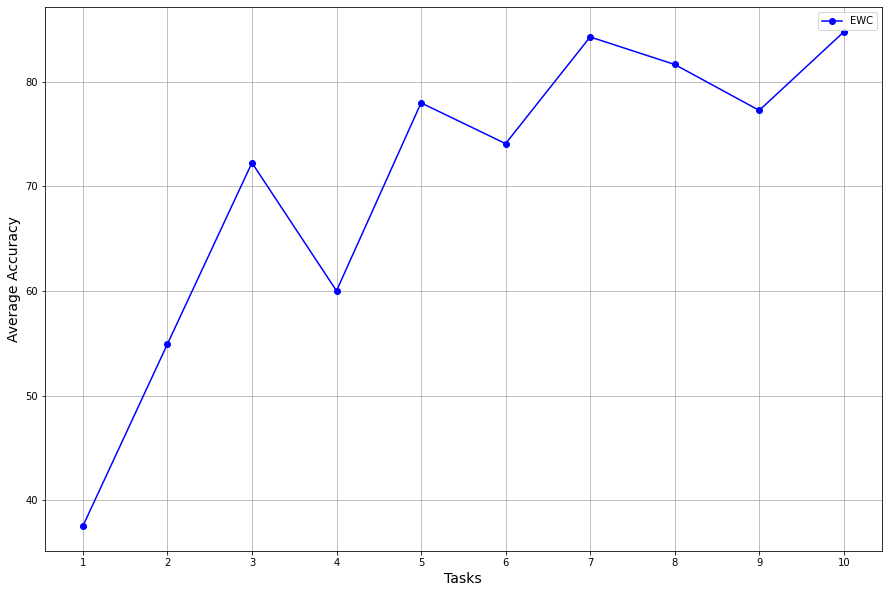

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
plt.plot([1, 2, 3,4,5,6,7,8,9,10], ewc_accs, '-o', label="EWC", color = 'b')
plt.xlabel('Tasks', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)

ax.grid()
# plt.title('CL Strategies Comparison on MNIST', fontsize=14);
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.legend(prop={'size': 10});



```
# This is formatted as code
```

**As we improved the EWC model from the starter code, we can see the acc for EWC imporved from the benchmark's 74% to85.78%.**

# Part IV: Explore on the ewc lambda: 
Since the **$\lambda$** in our EWC loss function decides how important the previous task's parameters when compared to the new task, so we would want to find the best **$\lambda$**  that fits our model which provides better accurracy: 

In this part, we explores different  **$\lambda$** values and run each of them for three tasks and then plot them together to find the best **$\lambda$** value for our model. 

From the experiment, we can see the best **$\lambda$** value for our MNIST dataset is 0.35, which we used in our PART III for compute the loss fucntion. 

In [ ]:
lam_dic = []
for i in range(10,100,5):
    test_lam = round(i*0.01,2)
    lam_dic.append(test_lam)

In [ ]:
i = 0
lam_acc =[]

for lambda_i in lam_dic: 
    print("current lambda: ", lambda_i)
    lam_diff_ewc_acc = []
    model = MLP().to(device)
    optimizer = optim.Adadelta(model.parameters())
    for id, task in enumerate(tasks[:5]):
        avg_acc = 0
        print("Training on task: ", id)

        (x_train, t_train), _ = task

        for epoch in range(1, 5):
            train_ewc(model, device, id, x_train, t_train, optimizer, epoch,lambda_i)
            on_task_update(id, x_train, t_train)

        for id_test, task in enumerate(tasks[:5]):
            print("Testing on task: ", id_test)
            _, (x_test, t_test) = task
            acc = test(model, device, x_test, t_test)
            avg_acc = avg_acc + acc

        print("Avg acc: ", avg_acc / 5)
        lam_diff_ewc_acc.append(avg_acc / 5)
    lam_acc.append(lam_diff_ewc_acc)

current lambda:  0.1
Training on task:  0
Train Epoch: 1 	Loss: 0.124066
Train Epoch: 2 	Loss: 0.092253
Train Epoch: 3 	Loss: 0.102709
Train Epoch: 4 	Loss: 0.093288
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 9758/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0049, Accuracy: 1673/10000 (17%)

Testing on task:  2
Test set: Average loss: 0.0038, Accuracy: 3216/10000 (32%)

Testing on task:  3
Test set: Average loss: 0.0001, Accuracy: 9758/10000 (98%)

Testing on task:  4
Test set: Average loss: 0.0038, Accuracy: 1774/10000 (18%)

Avg acc:  52.358000000000004
Training on task:  1
Train Epoch: 1 	Loss: 0.179284
Train Epoch: 2 	Loss: 0.116168
Train Epoch: 3 	Loss: 0.092259
Train Epoch: 4 	Loss: 0.080831
Testing on task:  0
Test set: Average loss: 0.0022, Accuracy: 4473/10000 (45%)

Testing on task:  1
Test set: Average loss: 0.0001, Accuracy: 9696/10000 (97%)

Testing on task:  2
Test set: Average loss: 0.0037, Accuracy: 2224/10000 (22%)

Testing on task:  3


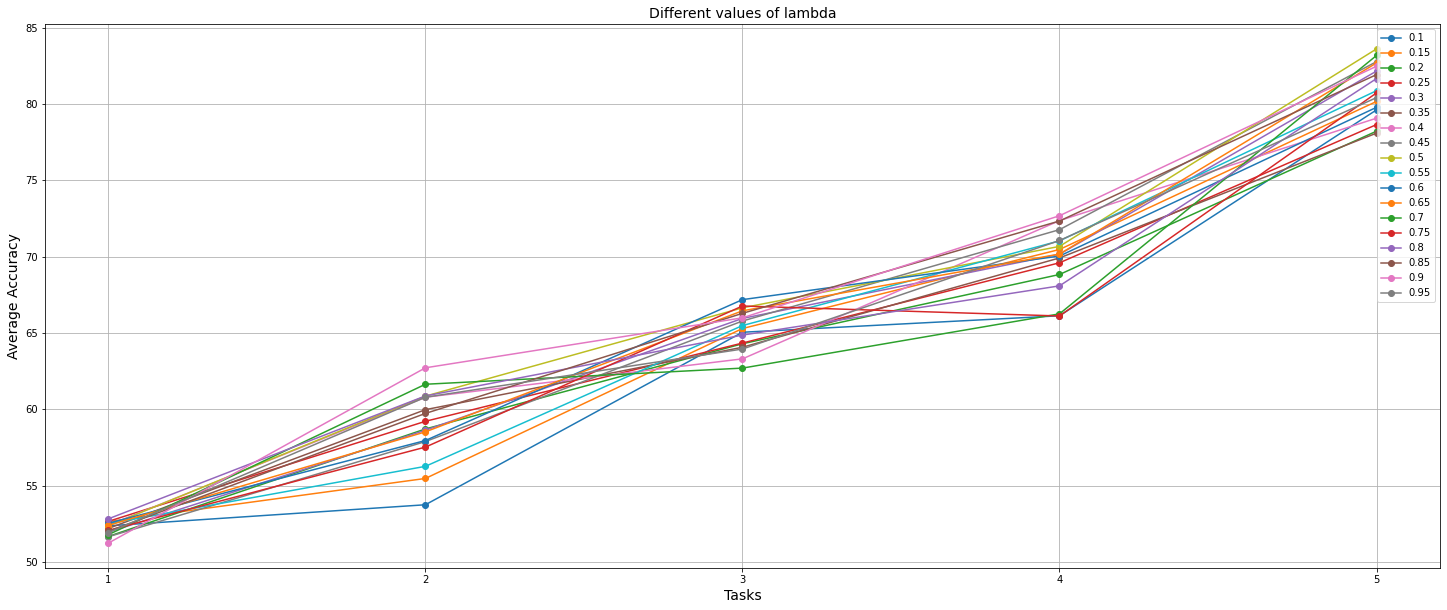

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
ax.grid()

n = 0.1
for i in lam_acc: 
    plt.plot([1, 2, 3, 4, 5],i, '-o', label= n)
    plt.xlabel('Tasks', fontsize=14)
    plt.ylabel('Average Accuracy', fontsize=14)
    plt.title('Different values of lambda', fontsize=14);
    plt.xticks([1, 2, 3, 4, 5])
    plt.legend(prop={'size': 10})
    n += 0.05
    n = round(n,2)
